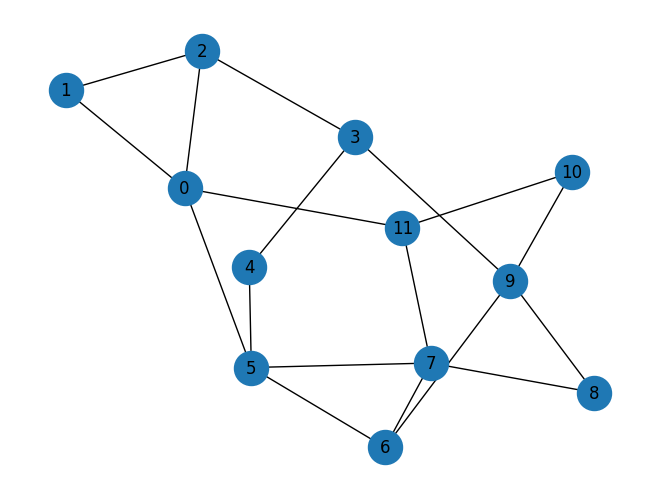

In [1]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np

n = 12

graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [(0, 1, 1.0), (0,11, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0), (4, 5, 1.0), (5, 6, 1.0), (6, 7, 1.0), (7, 8, 1.0), (8, 9, 1.0), (9, 10, 1.0), (10, 11, 1.0), (0, 2 ,1.0), (0, 5, 1.0), (7, 11, 1.0), (5, 7, 1.0), (3, 9, 1.0), (6, 9, 1.0)]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [2]:
from qiskit.quantum_info import SparsePauliOp
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list


max_cut_paulis = build_max_cut_paulis(graph)

cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIIIIIIIIZZ', 'ZIIIIIIIIIIZ', 'IIIIIIIIIZZI', 'IIIIIIIIZZII', 'IIIIIIIZZIII', 'IIIIIIZZIIII', 'IIIIIZZIIIII', 'IIIIZZIIIIII', 'IIIZZIIIIIII', 'IIZZIIIIIIII', 'IZZIIIIIIIII', 'ZZIIIIIIIIII', 'IIIIIIIIIZIZ', 'IIIIIIZIIIIZ', 'ZIIIZIIIIIII', 'IIIIZIZIIIII', 'IIZIIIIIZIII', 'IIZIIZIIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


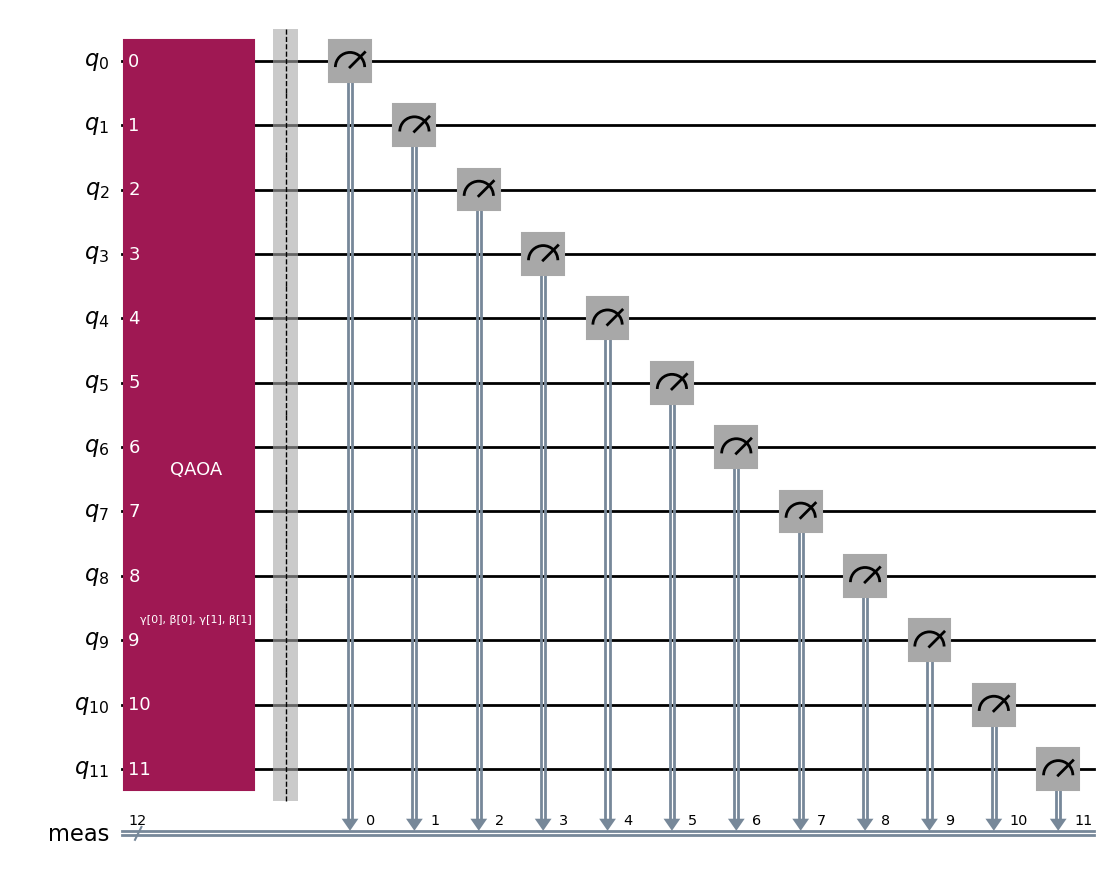

In [3]:
from qiskit.circuit.library import QAOAAnsatz

circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
circuit.measure_all()

circuit.draw('mpl')

In [4]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])])

AerSimulator('aer_simulator')


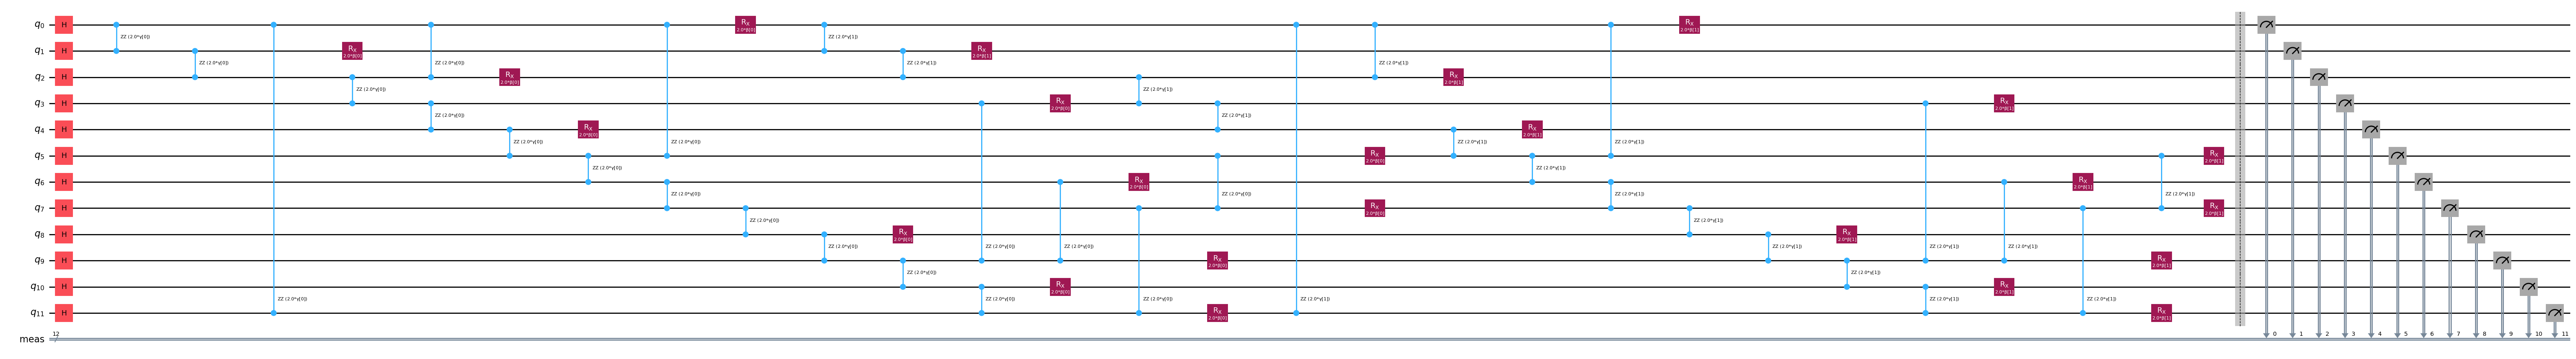

In [7]:
# Use a local simulator
from qiskit_aer import AerSimulator
 
# Generate a simulator
backend = AerSimulator()
print(backend)

# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=backend)

candidate_circuit = pm.run(circuit)
candidate_circuit.draw('mpl', fold=False, idle_wires=False)

In [8]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta, initial_gamma, initial_beta]

In [9]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)


    return cost

In [10]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from scipy.optimize import minimize

objective_func_vals = [] # Global variable
with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session) 
    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, cost_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-2,
    )
    print(result)

c:\Users\user1\miniconda3\envs\qiskit\Lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:234: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
c:\Users\user1\miniconda3\envs\qiskit\Lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:234: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
c:\Users\user1\miniconda3\envs\qiskit\Lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:234: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -7.3006993006993
       x: [ 3.329e+00  2.839e+00  2.780e+00  6.859e-01]
    nfev: 38
   maxcv: 0.0


c:\Users\user1\miniconda3\envs\qiskit\Lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:234: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
c:\Users\user1\miniconda3\envs\qiskit\Lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:234: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
c:\Users\user1\miniconda3\envs\qiskit\Lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:234: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True

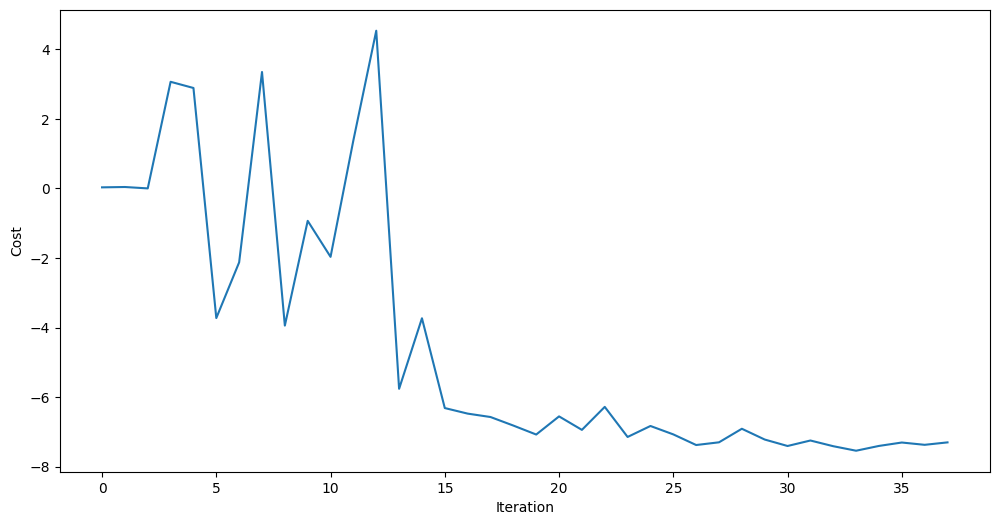

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

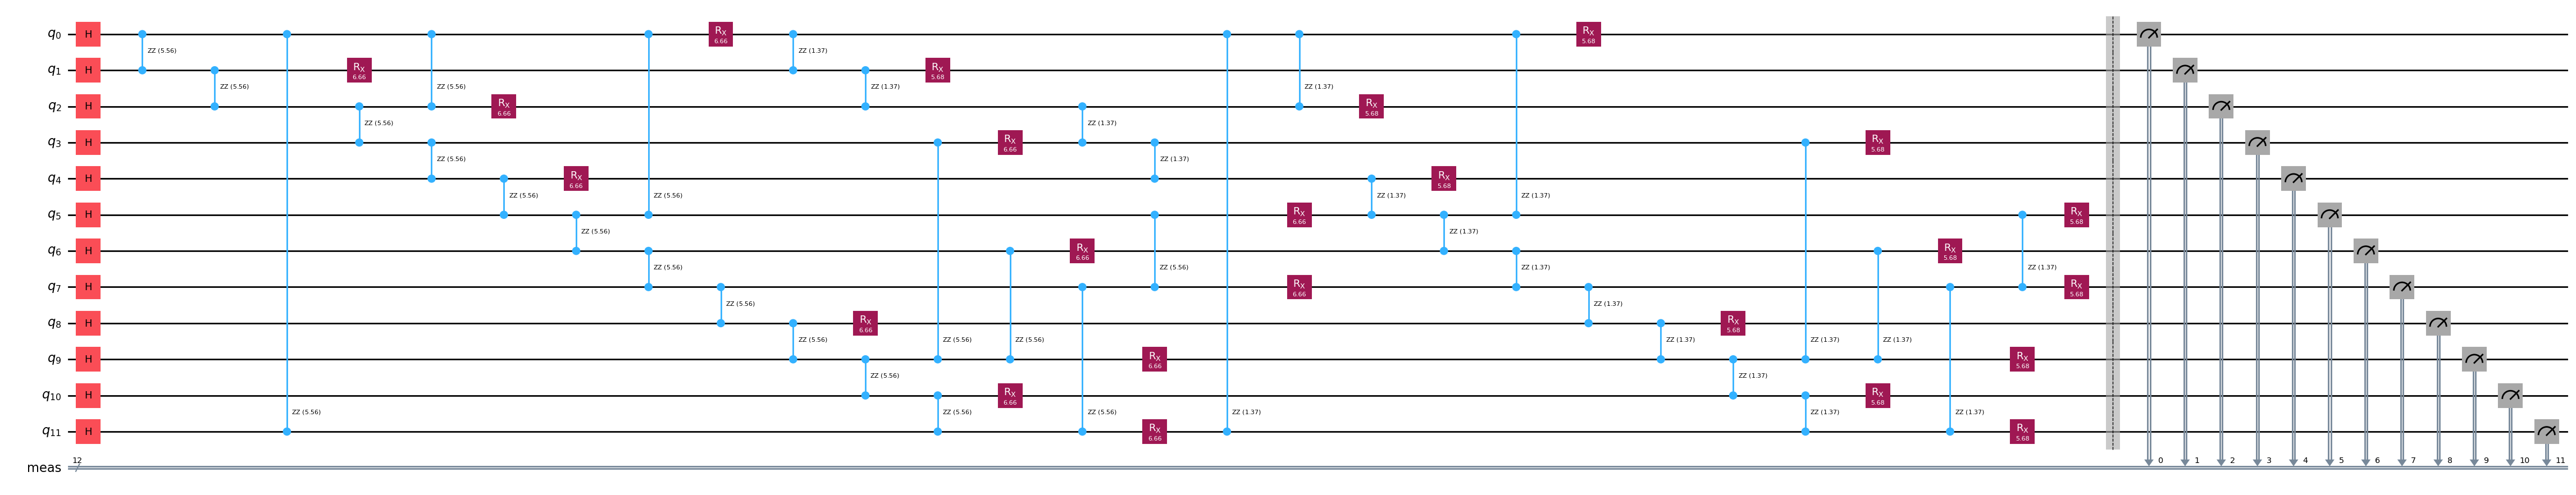

In [13]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw('mpl', fold=False, idle_wires=False)

In [14]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

{3756: 0.0007, 2858: 0.0074, 1225: 0.0071, 2730: 0.0115, 1708: 0.0006, 1697: 0.0006, 2928: 0.0002, 2011: 0.0001, 1844: 0.0003, 2393: 0.0037, 2394: 0.0023, 2412: 0.0063, 1321: 0.0029, 3097: 0.0001, 2770: 0.0008, 1687: 0.0015, 689: 0.0001, 1513: 0.001, 1787: 0.0002, 649: 0.0037, 1161: 0.0018, 337: 0.0002, 1371: 0.0061, 3372: 0.002, 651: 0.0025, 1365: 0.0103, 3434: 0.0165, 2390: 0.0033, 3436: 0.0088, 693: 0.0007, 2386: 0.0013, 2901: 0.0053, 715: 0.001, 1493: 0.0086, 683: 0.0043, 2476: 0.0008, 659: 0.0084, 2614: 0.0042, 1547: 0.0002, 3417: 0.0017, 1867: 0.0002, 1685: 0.015, 1435: 0.0024, 1961: 0.0005, 3465: 0.0001, 1706: 0.0036, 1387: 0.0054, 3370: 0.0041, 2645: 0.0028, 724: 0.0004, 1243: 0.0063, 2660: 0.0022, 1384: 0.0016, 2708: 0.0045, 2408: 0.0014, 1497: 0.0054, 2336: 0.0001, 1749: 0.0054, 1171: 0.0005, 1259: 0.0005, 3421: 0.0011, 1396: 0.0006, 3430: 0.0017, 1481: 0.0053, 1813: 0.0003, 3180: 0.0008, 725: 0.0042, 691: 0.0007, 1683: 0.0073, 1066: 0.0012, 1386: 0.0051, 1316: 0.0009, 2634: 

c:\Users\user1\miniconda3\envs\qiskit\Lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:234: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


In [15]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1]


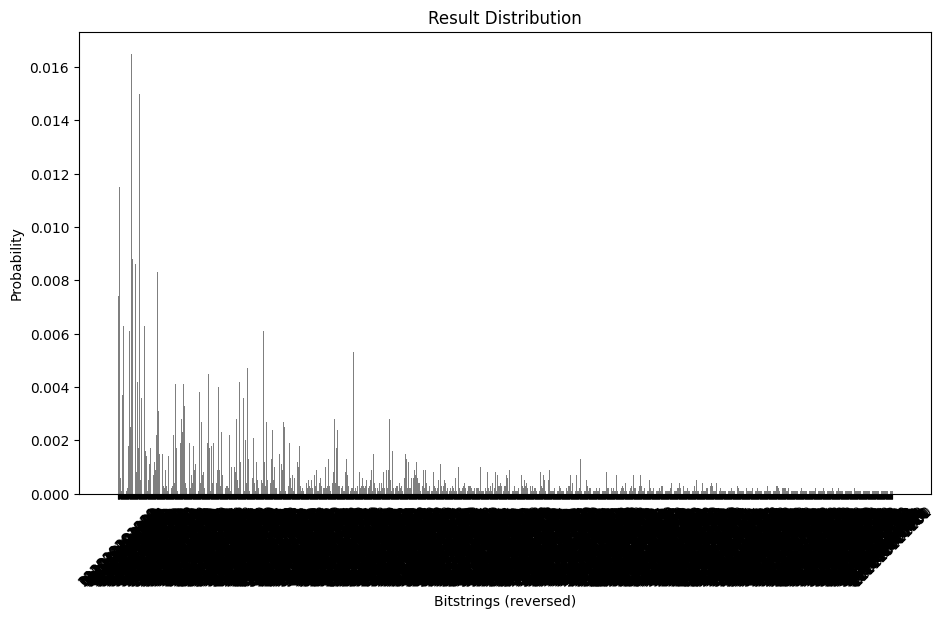

In [16]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")


plt.show()


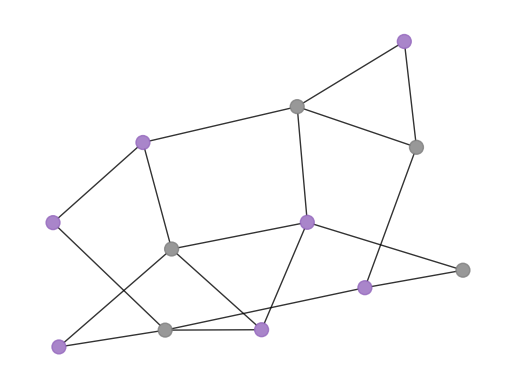

In [17]:
# auxiliary function to plot graphs
def plot_result(G, x):
    colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    pos, default_axes = rx.spring_layout(G), plt.axes(frameon=True)
    rx.visualization.mpl_draw(G, node_color=colors, node_size=100, alpha=0.8, pos=pos)


plot_result(graph, most_likely_bitstring)

In [18]:
from typing import Sequence
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "The length of x must coincide with the number of nodes in the graph."
    return sum(x[u] * (1 - x[v]) + x[v] * (1 - x[u]) for u, v in list(graph.edge_list()))


cut_value= evaluate_sample(most_likely_bitstring, graph)
print('The value of the cut is:', cut_value)

The value of the cut is: 15
